# MLP!

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# read in all the names
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

In [9]:
# build the vocab of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# 11:04

In [10]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
X.shape, X.dtype,  Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [13]:
C = torch.randn((27,2))
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [15]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.8005, -0.6532,  0.9995,  ..., -0.4633, -0.8791, -0.9798],
        [-0.7103,  0.6449,  0.9886,  ..., -0.8758, -0.9999, -0.8951],
        [-0.3745,  0.7594,  0.6523,  ..., -0.1188, -0.9989, -0.9513],
        ...,
        [ 1.0000, -0.7707,  0.9960,  ...,  0.9995,  0.9972, -1.0000],
        [ 0.9993,  0.9993, -0.9832,  ..., -0.3201,  0.9999,  0.9953],
        [ 0.9899, -0.8219,  0.7560,  ...,  0.6418, -0.7011,  0.9964]])

In [16]:
h.shape

torch.Size([228146, 100])

In [17]:
W2 = torch.randn((100,27))
b2 = torch.randn((27))

In [18]:
logits = h @ W2 + b2

In [19]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [22]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## 32:01

In [ ]:
# ------ more respectable --------

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [33]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [34]:
sum(p.nelement() for p in parameters)

11897

In [35]:
for p in parameters:
    p.requires_grad = True

In [27]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [52]:
lri = []
lossi = []
stepi = []

from tqdm import tqdm

ITERS = 200000
def calcLr(i):
    if i < 0.2 * ITERS:
        return 0.2
    if i < 0.3 * ITERS:
        return 0.1
    if i < 0.5 * ITERS:
        return 0.05
    if i < 0.7 * ITERS:
        return 0.03
    else:
        return 0.01

In [53]:
for i in tqdm(range(ITERS)):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = calcLr(i)
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


100%|██████████| 200000/200000 [02:11<00:00, 1526.54it/s]


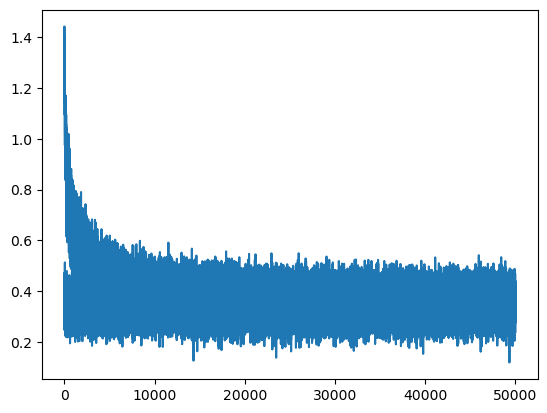

In [47]:
plt.plot(stepi, lossi)

In [54]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0702, grad_fn=<NllLossBackward0>)

In [55]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1256, grad_fn=<NllLossBackward0>)

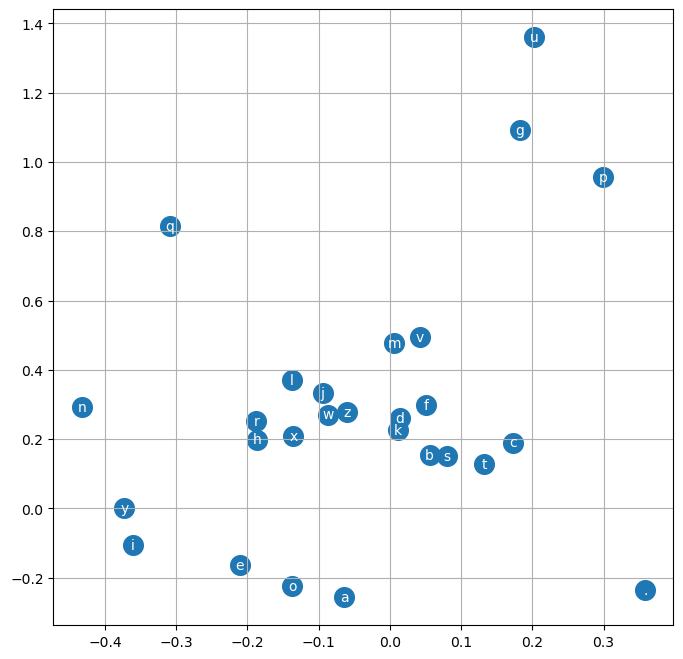

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%
# model params, hyperparams (size of hidden layers, length of embeddings), evaluate the performance of the model at the end

## 1:04:00

## end of video 2